In [27]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import pickle
import matplotlib.pyplot as plt
import numpy as np

In [28]:
df = pd.read_csv('dataNameEncoded.csv')

In [29]:
df.head(2)

,name_0,name_1,name_2,name_3,name_4,name_5,name_6,name_7,health_expenditure,who_region,...,year,population,life_expectancy,health_life_expectancy,Number of new HIV infections,Suicide deaths,Adult obesity%,Tobacco use%,Alcohol consumption,Prevalence of hypertension%
0,0,0,0,0,0,0,0,1,21.83,2,...,2000,0.0,55.00,46.80,0.0,4.1,2.1,20.0,0.0,44.249837
1,0,0,0,0,0,0,0,1,21.83,2,...,2001,0.0,55.49,47.23,0.0,4.9,2.1,20.0,0.0,35.839694


In [30]:
target_indicators = [ 'Adult obesity%',
                     'Tobacco use%', 'Alcohol consumption','Number of new HIV infections', 'Suicide deaths', 'Prevalence of hypertension%']


In [31]:
feature_columns = ['health_expenditure', 'who_region', 'world_bank_income_level',
                   'population growth rate%', 'year', 'population', 'life_expectancy', 
                   'health_life_expectancy'] + list(df.columns[df.columns.str.startswith('name_')])


### Models


1. **RandomForest**: <br>
RandomForest handles both numerical and categorical features well, making it ideal for diverse indicators like life expectancy, tobacco use, and population growth. Its ensemble approach makes predictions more accurate and stable across different types of data in your dataset.

2. **GradientBoosting**: <br>
This model refines predictions by focusing on areas with higher errors in previous trees, which helps capture complex relationships in indicators like health expenditure and hypertension. It's excellent for structured data and provides robust results even with noisy inputs.

3. **Neural Network (MLPRegressor)**: <br>
Neural networks can model complex patterns within the data, such as connections between health factors and year-based trends. Given the varied nature of indicators, the network’s layered structure is effective for learning these intricate relationships.

4. **XGBoost**: <br>
XGBoost is great at handling high-dimensional and sparse data, which aligns well with our wide array of indicators. It’s powerful in terms of predictive accuracy and is designed to handle complex patterns efficiently, making it a strong model for detailed health and population indicators.

In [32]:
R2_THRESHOLD = 0.93

In [33]:
model_performance = {indicator: {} for indicator in target_indicators}


In [34]:
for indicator in target_indicators:
    indicator_data = df.dropna(subset=[indicator])
    X = indicator_data[feature_columns]
    y = indicator_data[indicator]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    models = {
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "NeuralNetwork": MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42),
        "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
    }

    best_score = float('-inf')
    best_model = None
    best_model_name = ""

    for model_name, model in models.items():
        model.fit(X_scaled, y)
        y_pred = model.predict(X_scaled)
        score = r2_score(y, y_pred)

        model_performance[indicator][model_name] = score

        if score > best_score and score <= R2_THRESHOLD:
            best_score = score
            best_model = model
            best_model_name = model_name

    print(f"Best model for {indicator}: {best_model_name} with R² score of {best_score}\n")

    if best_model:
        with open(f'../models/pklFiles/scaler_{indicator}.pkl', 'wb') as file:
            pickle.dump(scaler, file)
        with open(f'../models/pklFiles/best_model_{indicator}.pkl', 'wb') as file:
            pickle.dump(best_model, file)





Best model for Adult obesity%: RandomForest with R² score of 0.8428389913535146

Best model for Tobacco use%: RandomForest with R² score of 0.8447471626619104

Best model for Alcohol consumption: RandomForest with R² score of 0.8431718472325553

Best model for Number of new HIV infections: GradientBoosting with R² score of 0.9101183519448056

Best model for Suicide deaths: GradientBoosting with R² score of 0.8297899579225261

Best model for Prevalence of hypertension%: RandomForest with R² score of 0.8409895181015177



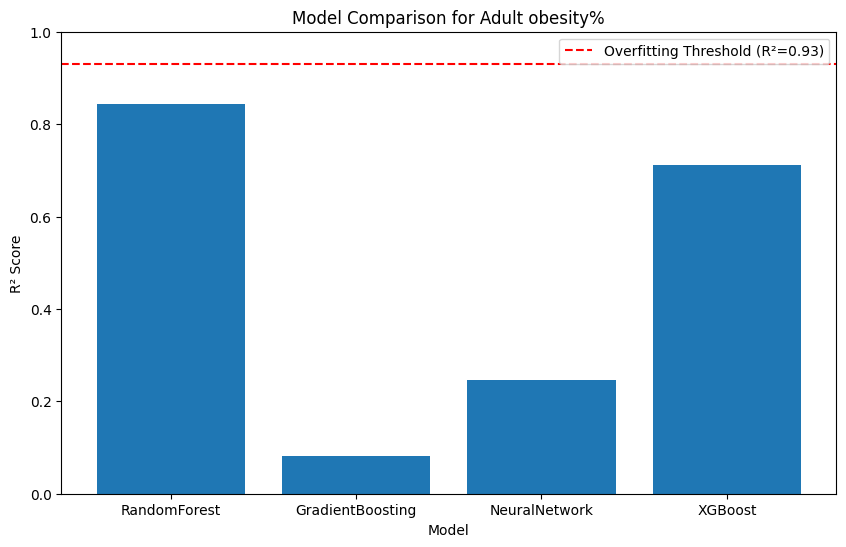

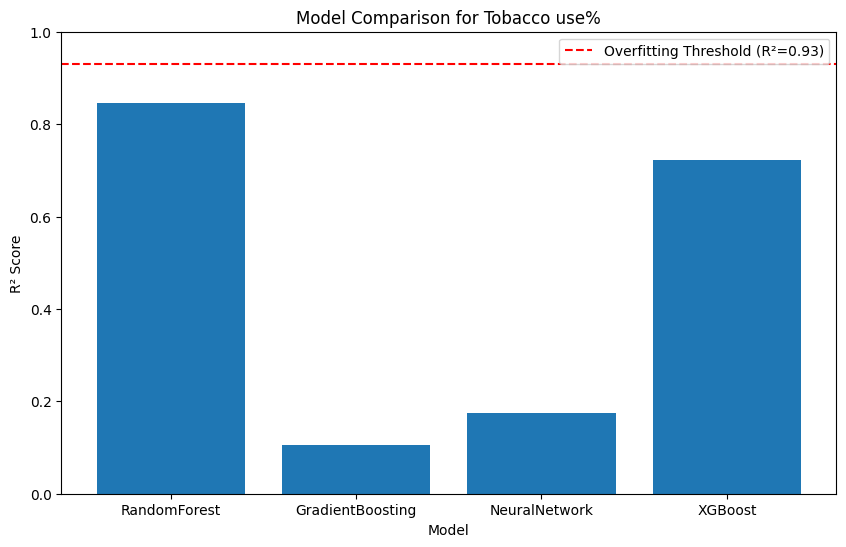

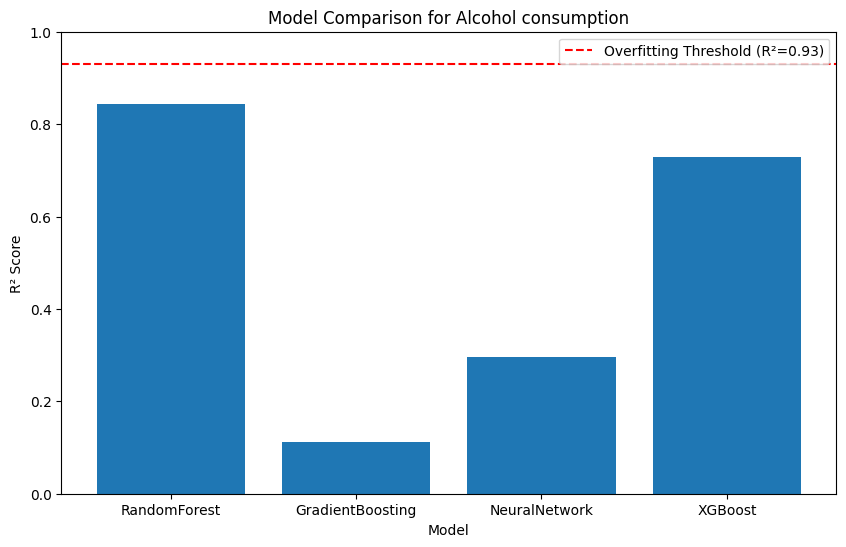

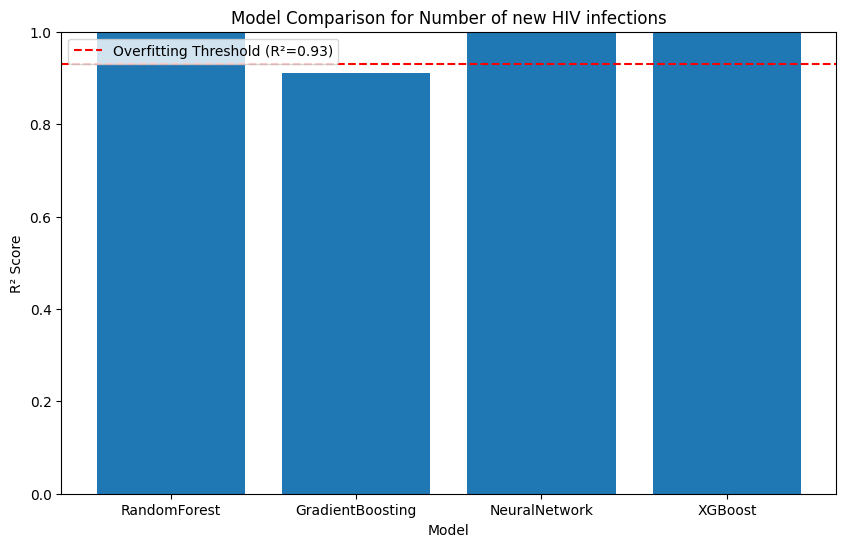

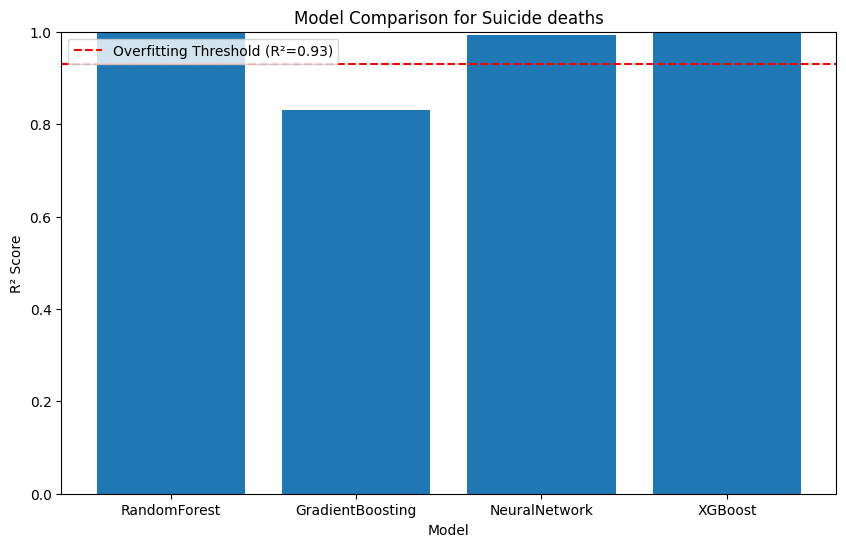

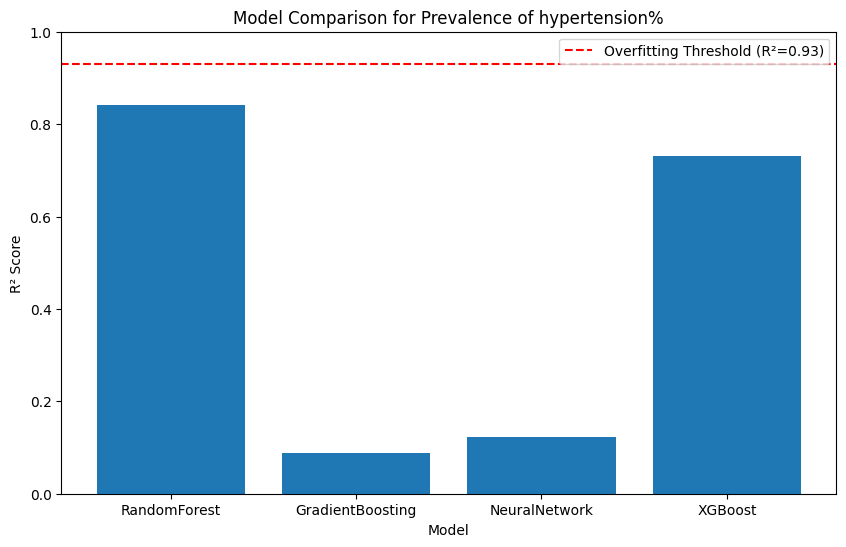

In [ ]:
#### gettting prediction


import pickle
import pandas as pd

# Load encoder
with open('../preprocessing/country_binary_encoder.pkl', 'rb') as file:
    binary_encoder = pickle.load(file)

# Load scaler and model for a specific indicator (e.g., 'Suicide deaths')
indicator = 'Suicide deaths'
with open(f'../models/scaler_{indicator}.pkl', 'rb') as file:
    scaler = pickle.load(file)
with open(f'../models/model_{indicator}.pkl', 'rb') as file:
    model = pickle.load(file)

input_data = {
    'name': 'Afghanistan',
    'health_expenditure': 22.0,
    'who_region': 2,
    'world_bank_income_level': 1,
    'population growth rate%': 2.5,
    'year': 2025,
    'population': 39000000,
    'life_expectancy': 60.0,
    'health_life_expectancy': 50.0
}

# Convert to DataFrame
input_df = pd.DataFrame([input_data])


# Apply the binary encoder to the 'name' column
input_df_encoded = binary_encoder.transform(input_df)

# Extract feature columns for the model
feature_columns = [
    'health_expenditure', 'who_region', 'world_bank_income_level',
    'population growth rate%', 'year', 'population', 'life_expectancy', 
    'health_life_expectancy'
] + list(input_df_encoded.columns[input_df_encoded.columns.str.startswith('name_')])

# Scale the data
input_scaled = scaler.transform(input_df_encoded[feature_columns])


# Predict the target indicator (e.g., 'Suicide deaths') for the input data
prediction = model.predict(input_scaled)

print(f"Predicted {indicator}: {prediction[0]}")
for indicator, performance in model_performance.items():
    plt.figure(figsize=(10, 6))
    plt.bar(performance.keys(), performance.values())
    plt.title(f'Model Comparison for {indicator}')
    plt.xlabel('Model')
    plt.ylabel('R² Score')
    plt.ylim(0, 1)
    plt.axhline(R2_THRESHOLD, color='red', linestyle='--', label=f'Overfitting Threshold (R²={R2_THRESHOLD})')
    plt.legend()
    plt.show()